In [ ]:
from google.colab import files
uploaded = files.upload()


Saving MSFT_train_data.csv to MSFT_train_data.csv


In [ ]:
# === 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from collections import Counter

# === 2. List of tickers to process
tickers = ["AAPL", "AMZN", "GOOG", "INTC", "MSFT"]

# === 3. Prepare dictionaries to store all results
all_df_final = {}
all_exec_df = {}
all_benchmark_df = {}

# === 4. Process each ticker
for ticker in tickers:
    print(f"\n\n===========================")
    print(f"Running for {ticker}")
    print(f"===========================")

    # Load data
    df = pd.read_csv(f"{ticker}_train_data.csv")  # Make sure all files are uploaded

    # Feature Engineering
    df["mid_price"] = (df["ask price"] + df["bid price"]) / 2
    df["spread"] = df["ask price"] - df["bid price"]
    df["order_imbalance"] = (df["bid volume"] - df["ask volume"]) / (df["bid volume"] + df["ask volume"])
    df["time_seconds"] = df["time"] - df["time"].min()
    df["mid_price_future"] = df["mid_price"].shift(-5)
    df["momentum"] = df["mid_price"] - df["mid_price"].shift(5)
    df["order_direction_mean"] = df["order direction (-1:sell, 1:buy)"].rolling(10).mean()
    df["is_execution"] = df["order type (1:submission_of_new_limit, 2:partial_cancelation, 3:total_cancelation, 4:execution_of_visible, 5:execution_of_hidden, 7:trading_halt)"].isin([4, 5]).astype(int)
    df["execution_intensity"] = df["is_execution"].rolling(10).mean()
    df["vwap"] = (df["order price"] * df["size"]).rolling(10).sum() / df["size"].rolling(10).sum()

    # Labeling (lowest 3% of ask prices)
    minute_start = int(df["time_seconds"].min()) // 60
    minute_end = int(df["time_seconds"].max()) // 60
    df["label"] = 0
    for m in range(minute_start, minute_end + 1):
        rows = df[(df["time_seconds"] >= m * 60) & (df["time_seconds"] < (m + 1) * 60)]
        if not rows.empty:
            threshold = rows["ask price"].quantile(0.03)
            df.loc[rows[rows["ask price"] <= threshold].index, "label"] = 1

    # Prepare data
    features = ["spread", "order_imbalance", "momentum", "execution_intensity", "order_direction_mean", "vwap"]
    df_final = df.dropna(subset=features + ["label", "mid_price", "mid_price_future"])
    X = df_final[features]
    y = df_final["label"]

    # Normalize and split
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # SMOTE rebalancing
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print("✅ Balanced class counts:", Counter(y_resampled))

    # Train MLP
    mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
    mlp.fit(X_resampled, y_resampled)

    # Evaluate
    y_pred = mlp.predict(X_test)
    print("📊 Evaluation Report:\n", classification_report(y_test, y_pred))

    # Execution logic
    def get_time_dependent_threshold(t):
        if t < 15:
            return 0.95
        elif t < 30:
            return 0.90
        elif t < 45:
            return 0.85
        else:
            return 0.80

    executions = []
    for m in range(minute_start, minute_end + 1):
        minute_rows = df_final[(df_final["time_seconds"] >= m * 60) & (df_final["time_seconds"] < (m + 1) * 60)]
        trade_made = False
        for idx, row in minute_rows.iterrows():
            t = row["time_seconds"] % 60
            threshold = get_time_dependent_threshold(t)

            x_live_df = pd.DataFrame([row[features].values], columns=features)
            x_live_scaled = scaler.transform(x_live_df)
            proba = mlp.predict_proba(x_live_scaled)[0, 1]

            if proba > threshold:
                executions.append({
                    "index": idx,
                    "minute": m,
                    "algo_price": row["ask price"]
                })
                trade_made = True
                break

        if not trade_made and not minute_rows.empty:
            fallback_row = minute_rows.iloc[-1]
            executions.append({
                "index": fallback_row.name,
                "minute": m,
                "algo_price": fallback_row["ask price"]
            })

    exec_df = pd.DataFrame(executions)

    # Benchmark (last second buys)
    benchmark_execs = []
    for m in exec_df["minute"].unique():
        rows = df_final[(df_final["time_seconds"] >= m * 60) & (df_final["time_seconds"] < (m + 1) * 60)]
        if not rows.empty:
            last_row = rows.iloc[-1]
            benchmark_execs.append({
                "minute": m,
                "benchmark_price": last_row["ask price"]
            })

    benchmark_df = pd.DataFrame(benchmark_execs)

    # Compare
    comparison = pd.merge(exec_df, benchmark_df, on="minute", how="inner")
    comparison["price_diff"] = comparison["algo_price"] - comparison["benchmark_price"]

    print(f"\n🎯 Final Evaluation for {ticker}:")
    print(f"Total executions: {len(comparison)}")
    print(f"Average algo price: {comparison['algo_price'].mean():.5f}")
    print(f"Average benchmark price: {comparison['benchmark_price'].mean():.5f}")
    print(f"Average price difference: {comparison['price_diff'].mean():.5f}")

    # === Save to dictionary for visualization ===
    all_df_final[ticker] = df_final.copy()
    all_exec_df[ticker] = exec_df.copy()
    all_benchmark_df[ticker] = benchmark_df.copy()






Running for AAPL
✅ Balanced class counts: Counter({0: 62650, 1: 62650})
📊 Evaluation Report:
               precision    recall  f1-score   support

           0       0.97      0.75      0.85     26872
           1       0.13      0.66      0.22      1563

    accuracy                           0.74     28435
   macro avg       0.55      0.70      0.53     28435
weighted avg       0.93      0.74      0.81     28435


🎯 Final Evaluation for AAPL:
Total executions: 352
Average algo price: 584.06440
Average benchmark price: 584.08264
Average price difference: -0.01824


Running for AMZN
✅ Balanced class counts: Counter({0: 29528, 1: 29528})
📊 Evaluation Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89     12697
           1       0.24      0.63      0.35      1103

    accuracy                           0.81     13800
   macro avg       0.60      0.73      0.62     13800
weighted avg       0.91      0.81      0.85     13800


🎯



Visualizations for AAPL


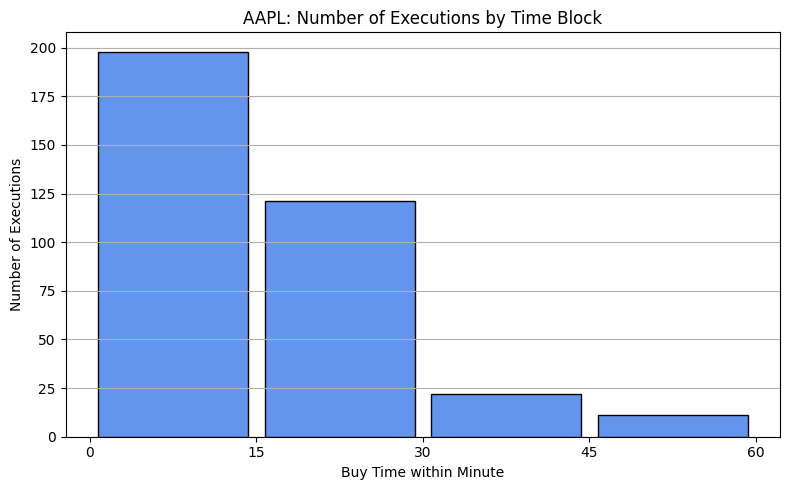

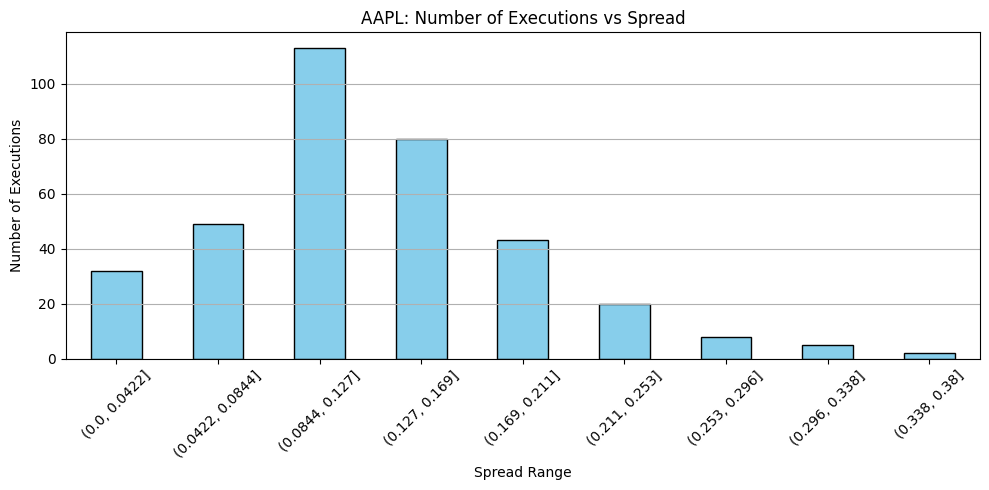

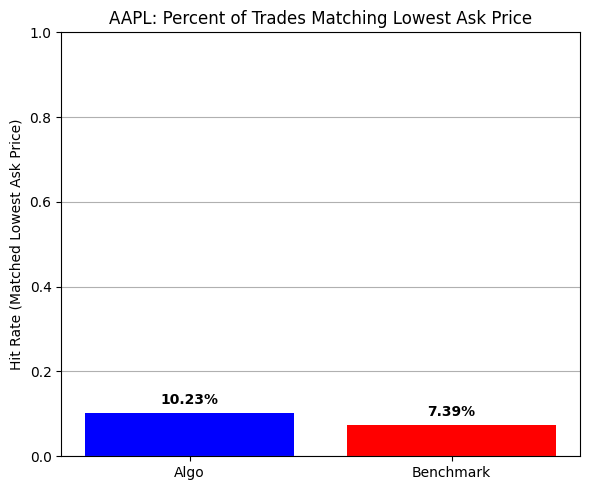



Visualizations for AMZN


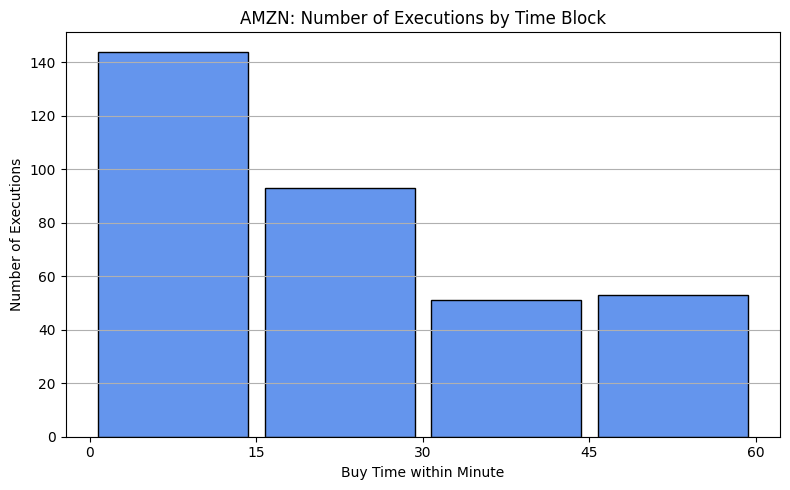

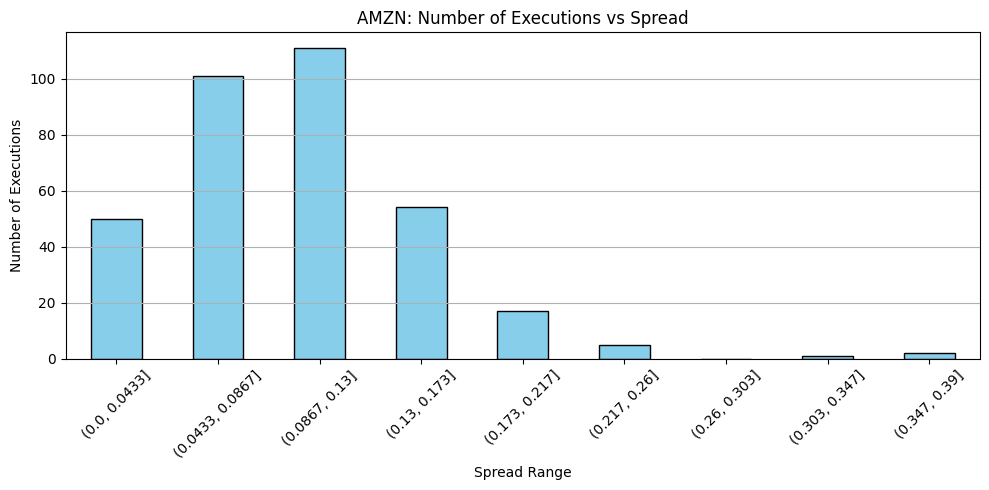

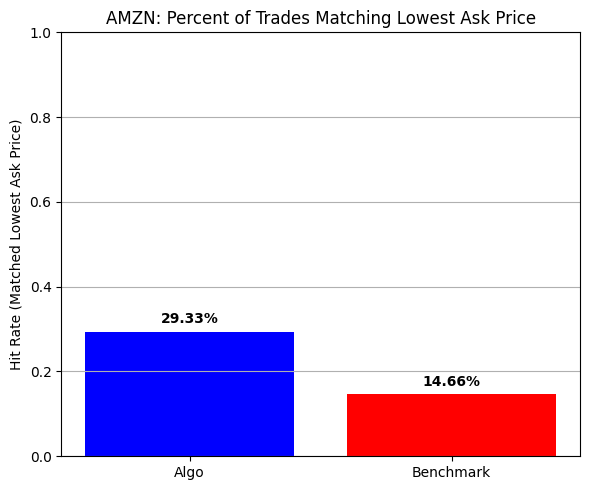



Visualizations for GOOG


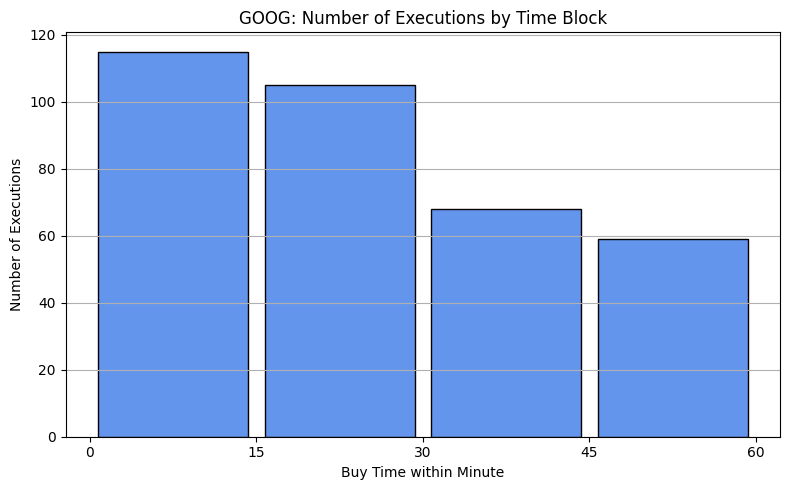

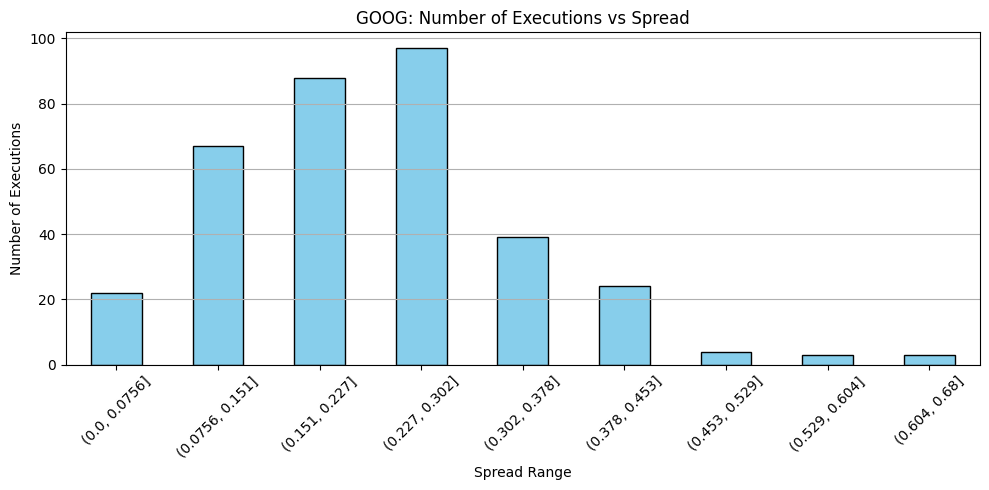

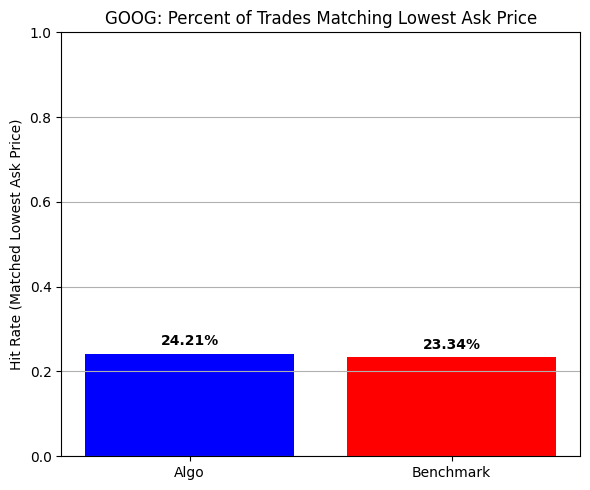



Visualizations for INTC


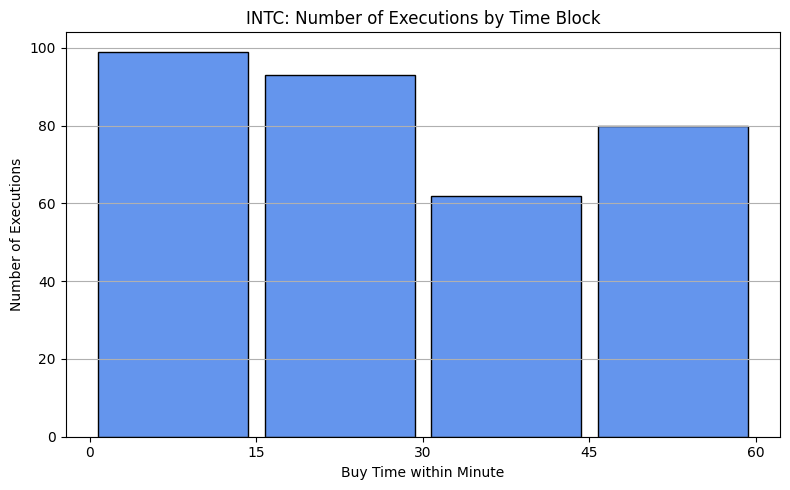

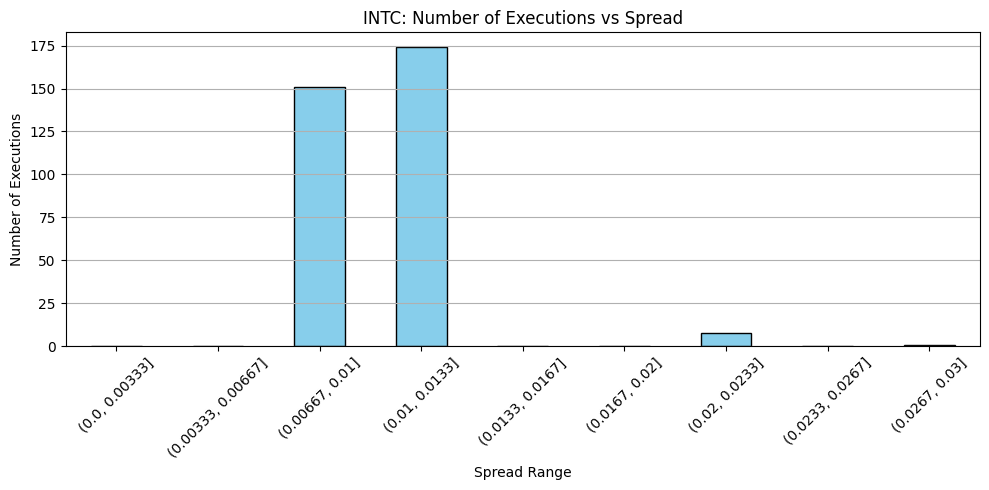

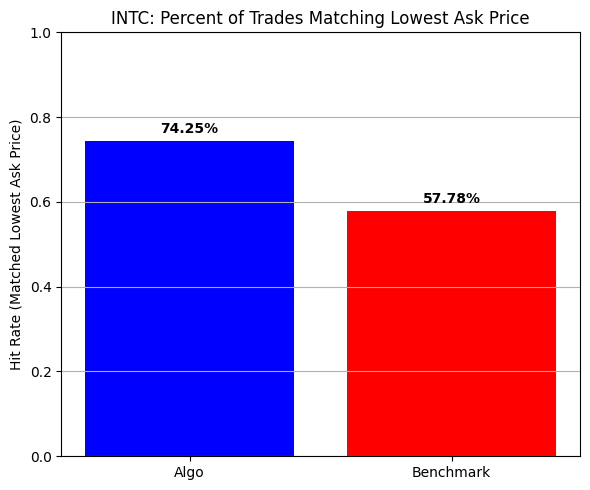



Visualizations for MSFT


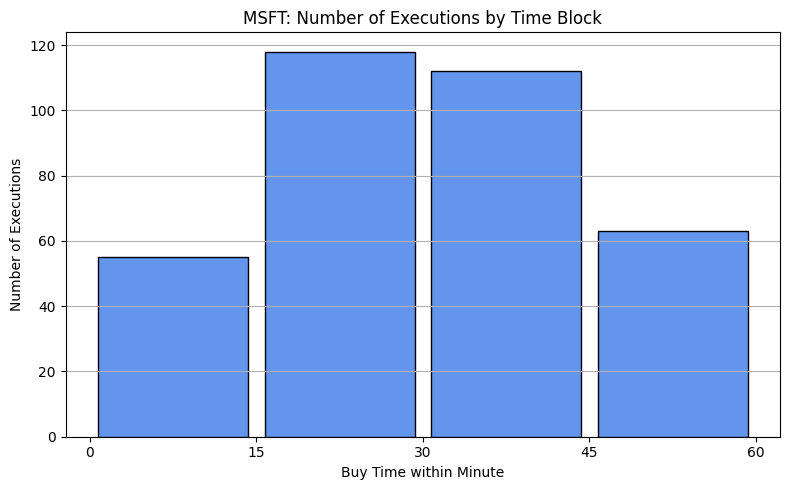

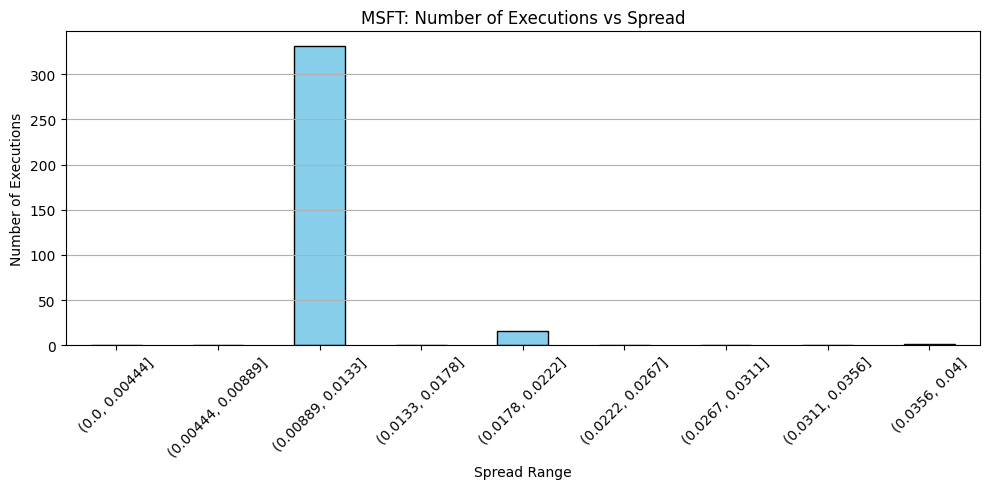

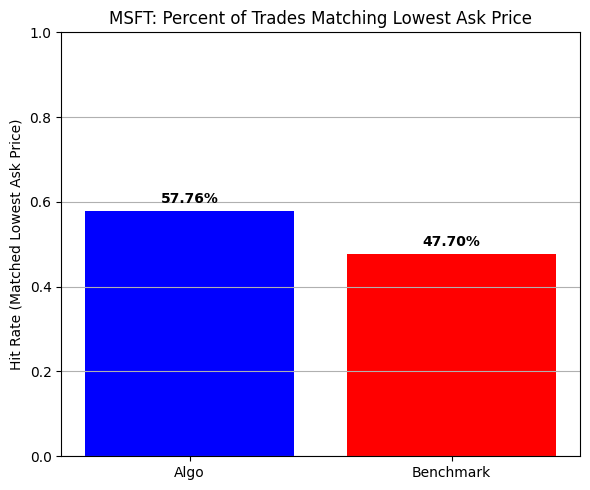

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

tickers = ["AAPL", "AMZN", "GOOG", "INTC", "MSFT"]

for ticker in tickers:
    print(f"\n\n===========================")
    print(f"Visualizations for {ticker}")
    print(f"===========================")

    df_final = all_df_final[ticker]
    exec_df = all_exec_df[ticker]
    benchmark_df = all_benchmark_df[ticker]

    # --- 1. Histogram: Execution Time Blocks (0-15, 15-30, 30-45, 45-60) ---
    algo_times = df_final.loc[exec_df["index"], "time_seconds"] % 60

    bins = [0, 15, 30, 45, 60]
    labels = ["0–15s", "15–30s", "30–45s", "45–60s"]

    plt.figure(figsize=(8, 5))
    plt.hist(algo_times, bins=bins, edgecolor='black', color='cornflowerblue', rwidth=0.9)
    plt.xticks(bins)
    plt.xlabel("Buy Time within Minute")
    plt.ylabel("Number of Executions")
    plt.title(f"{ticker}: Number of Executions by Time Block")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # --- 2. Histogram: Execution vs Spread ---
    exec_spreads = df_final.loc[exec_df["index"], "spread"]

    spread_bins = pd.cut(exec_spreads, bins=np.linspace(0, exec_spreads.max(), 10))
    spread_counts = spread_bins.value_counts().sort_index()

    plt.figure(figsize=(10, 5))
    spread_counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.xlabel("Spread Range")
    plt.ylabel("Number of Executions")
    plt.title(f"{ticker}: Number of Executions vs Spread")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # --- 3. Accuracy Comparison: Algo vs Benchmark Hit Rate ---
    df_final['minute'] = df_final["time_seconds"] // 60
    lowest_ask_per_minute = df_final.groupby("minute")["ask price"].min()

    # Compare algo executions to lowest
    algo_hits = 0
    for idx, row in exec_df.iterrows():
        minute = row["minute"]
        if abs(row["algo_price"] - lowest_ask_per_minute[minute]) < 1e-6:
            algo_hits += 1

    # Compare benchmark executions to lowest
    benchmark_hits = 0
    for idx, row in benchmark_df.iterrows():
        minute = row["minute"]
        if abs(row["benchmark_price"] - lowest_ask_per_minute[minute]) < 1e-6:
            benchmark_hits += 1

    total_trades = len(exec_df)
    algo_hit_rate = algo_hits / total_trades
    benchmark_hit_rate = benchmark_hits / total_trades

    plt.figure(figsize=(6, 5))
    plt.bar(["Algo", "Benchmark"], [algo_hit_rate, benchmark_hit_rate], color=["blue", "red"])
    plt.ylim(0, 1)
    plt.ylabel("Hit Rate (Matched Lowest Ask Price)")
    plt.title(f"{ticker}: Percent of Trades Matching Lowest Ask Price")
    for i, v in enumerate([algo_hit_rate, benchmark_hit_rate]):
        plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
